# Exploring key predictors of CS curriculums in Washington schools

### I. Introduction  
### II. Methodology  
#### II.A. Preprocessing  
#### II.C. Analysis of School Data
### III. Results
### IV. Conclusion


## I. Introduction

Access to Computer Science (CS) education in K-12 schools is not evenly distributed. This study leverages machine learning explainability techniques to identify the most important predictors of CS course availability, exploring how different methods reveal distinct insights about the factors that drive CS access.

Our analysis is based on data from the Washington State Office of Superintendent of Public Instruction (OSPI), the state education agency responsible for overseeing public education in Washington State. By using this dataset, we aim to provide a data-driven assessment of CS course availability across the state, helping to identify systemic factors that influence whether schools offer CS programs.

Traditional statistical methods often focus on direct correlations between features and outcomes, but machine learning models can capture more complex, non-linear relationships. To investigate these relationships, we employ Random Forest feature importance, Mutual Information, and Principal Component Analysis (PCA). Each of these methods evaluates feature significance in different ways:

* Random Forest feature importance identifies variables that contribute most to predictive accuracy, capturing both direct effects and feature interactions.
* Mutual Information measures the direct statistical dependency between each feature and CS availability, without accounting for interactions.
* Principal Component Analysis (PCA), which does not consider the target variable, highlights features that explain the most variance in the dataset.
By comparing these approaches, we assess both predictive and structural importance, revealing whether CS availability is driven by individual factors, feature interactions, or underlying data patterns. Our results indicate that District Size is the strongest predictor across multiple methods, with economic factors like Median Income and County Population also playing key roles. 

By identifying key traits associated with schools with CS programs, we can better understand the systemic barriers to CS education and explore targeted solutions to ensure broader, more equitable access to computer science learning opportunities.

## II. Methodology
### II.A. Preprocessing

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
ospi_data = pd.read_csv('2022_school_pt5.csv',  index_col=0)

In [3]:
ospi_data.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,...,D_NoDisability,DC_NoDisability,A_9,AC_9,A_10,AC_10,A_11,AC_11,A_12,AC_12
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,9,0,...,26,3,7,0,4,0,6,1,11,2
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,...,1086,140,382,51,328,44,321,29,250,45
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,30,8,...,57,16,18,9,15,2,14,1,13,5
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,57,9,...,107,14,32,5,35,3,25,3,21,7
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,89,0,...,142,0,16,0,51,0,41,0,59,0


In [4]:
len(ospi_data.index)

730

In [5]:
ospi_data = ospi_data.iloc[:,:-15]

In [6]:
def low_inc_perc(row):
    return row['I_LowIncome'] / row['AllStudents']

ospi_data['PercentLowIncome'] = ospi_data.apply(low_inc_perc, axis=1)

For the following, note that BIPOC does not include Asian in this calculation. The following calculation includes all reported racial identities except for Asian and white.

In [7]:
def number_bipoc(row):
    return (row['R_Native'] + row['R_Black'] + row['R_Hisp_Lat'] + row['R_HPI'] + row['R_TwoOrMore'])

ospi_data['R_BIPOC'] = ospi_data.apply(number_bipoc, axis=1)

In [8]:
def bipoc_perc(row):
    return (row['R_BIPOC']) / row['AllStudents']

ospi_data['PercentBIPOC'] = ospi_data.apply(bipoc_perc, axis=1)

### Preprocessing: Percentage of District Low Income and BIPOC

In [9]:
ospi_data['DistrictNumSchools'] = ospi_data.groupby('DistrictCode')['SchoolCode'].transform('size')
ospi_data['DistrictSize'] = ospi_data.groupby('DistrictCode')['AllStudents'].transform('sum')
ospi_data['DistrictLowIncome'] = ospi_data.groupby('DistrictCode')['I_LowIncome'].transform('sum')
ospi_data['DistrictPctLowIncome'] = ospi_data['DistrictLowIncome']/ospi_data['DistrictSize']
ospi_data['DistrictBIPOC'] = ospi_data.groupby('DistrictCode')['R_BIPOC'].transform('sum')
ospi_data['DistrictPctBIPOC'] = ospi_data['DistrictBIPOC']/ospi_data['DistrictSize']

In [10]:
columns_to_analyze = ['DistrictCode','SchoolCode','SchoolName','Longitude'
                      ,'Latitude','County','AllStudents','C_AllStudents', 'I_LowIncome', 'PercentLowIncome'
                      , 'R_BIPOC' ,'PercentBIPOC','DistrictNumSchools','DistrictSize','DistrictLowIncome','DistrictPctLowIncome'
                      ,'DistrictBIPOC','DistrictPctBIPOC']

reduced_ospi = ospi_data[columns_to_analyze]

### Preprocessing: Hot One Encoding
*Hot one encoding whether or not a school offers CS*  

In [11]:
reduced_ospi = reduced_ospi.copy()
reduced_ospi['CS_Offered'] = np.where(reduced_ospi['C_AllStudents'] == 0, 0, 1)

### Preprocessing: Percentage of District with CS

In [12]:
reduced_ospi['DistrictCS'] = reduced_ospi.groupby('DistrictCode')['CS_Offered'].transform('sum')
reduced_ospi['DistrictPctCS'] = reduced_ospi['DistrictCS']/reduced_ospi['DistrictNumSchools']

### Preprocessing: Adding County Population

In [13]:
census_df = pd.read_csv('co-est2023-alldata.csv',  index_col=0, encoding = 'latin')
wa_counties = census_df.loc[census_df['STNAME'] == 'Washington'].copy(deep=True)
wa_pop = wa_counties.loc[:, ('POPESTIMATE2023', 'CTYNAME')]
wa_pop = wa_pop[((wa_pop.CTYNAME != 'Washington'))].copy(deep=True)

In [14]:
def remove_county(row):
    return row['CTYNAME'][:-7]

wa_pop['County'] = wa_pop.apply(remove_county, axis=1)

In [15]:
wa_pop = wa_pop.loc[:, ('POPESTIMATE2023', 'County')]
reduced_ospi = pd.merge(wa_pop, reduced_ospi, how='outer', on='County')

In [16]:
reduced_ospi = reduced_ospi.rename(columns={"POPESTIMATE2023": "CountyPop"})

### Preprocessing: Using Longitude and Latitude

In [17]:
reduced_ospi['Western_WA'] = reduced_ospi['Longitude'].apply(lambda x: '1' if x < -122 else '0')

### Preprocessing: Binning

*Random forest and gradient boosting machines will benefit from binning.*

Advisor Lawrence Tanimoto created the following binning strategy based on domain knowledge:

(School income from original), Bands:  <20%, 20 – 40%, 40% - 60%, 60% - 80%, 80%+

(School size modified from original): <=100, 101 – 300, 301 – 900. 901 – 1800. 1801+

(Disadvantaged race/ethnic percentage): < 15%, 15% - 30%, 30% - 50%, 50% - 75%, 75%+

(Location):  (King),  (Pierce, Snohomish, Spokane, Clark), (All Others). 

In [18]:
income_bins = [-float('inf'), .20, .40, .60, .80, float('inf')]
income_labels = ['1', '2', '3', '4', '5']

size_bins = [-float('inf'), 100, 300, 900, 1800, float('inf')]
size_labels = ['1', '2', '3', '4', '5']

bipoc_bins = [-float('inf'), .15, .30, .50, .75, float('inf')]
bipoc_labels = ['1', '2', '3', '4', '5']

reduced_ospi['IncomeBinned'] = pd.cut(ospi_data['PercentLowIncome'], bins=income_bins, labels=income_labels)
reduced_ospi['SchoolSizeBinned'] = pd.cut(ospi_data['AllStudents'], bins=size_bins, labels=size_labels)
reduced_ospi['BIPOCBinned'] = pd.cut(ospi_data['PercentBIPOC'], bins=bipoc_bins, labels=bipoc_labels)

Investigating distributions of binned features:

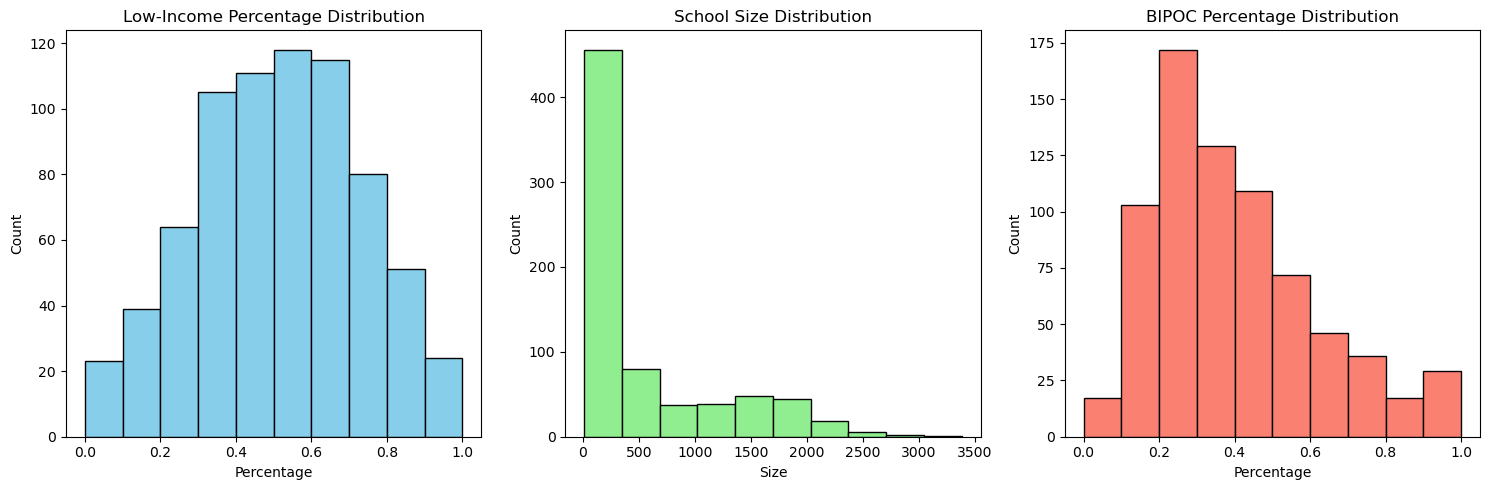

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df = reduced_ospi

income_col = 'PercentLowIncome'
size_col = 'AllStudents'
bipoc_col = 'PercentBIPOC'

# Plot histograms for each feature
plt.figure(figsize=(15, 5))

# Low-income percentage histogram
plt.subplot(1, 3, 1)
plt.hist(df[income_col], bins=10, color='skyblue', edgecolor='black')
plt.title('Low-Income Percentage Distribution')
plt.xlabel('Percentage')
plt.ylabel('Count')

# School size histogram
plt.subplot(1, 3, 2)
plt.hist(df[size_col], bins=10, color='lightgreen', edgecolor='black')
plt.title('School Size Distribution')
plt.xlabel('Size')
plt.ylabel('Count')

# BIPOC percentage histogram
plt.subplot(1, 3, 3)
plt.hist(df[bipoc_col], bins=10, color='salmon', edgecolor='black')
plt.title('BIPOC Percentage Distribution')
plt.xlabel('Percentage')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

An alternative binning strategy using quantiles:

In [20]:
reduced_ospi['IncomeBinnedQtl'] = pd.qcut(ospi_data['PercentLowIncome'], 5, labels=['1', '2', '3', '4', '5'])
reduced_ospi['SchoolSizeBinnedQtl'] = pd.qcut(ospi_data['AllStudents'], 5, labels=['1', '2', '3', '4', '5'])
reduced_ospi['BIPOCBinnedQtl'] = pd.qcut(ospi_data['PercentBIPOC'], 5, labels=['1', '2', '3', '4', '5'])

### Preprocessing: Adding median household income by county feature
This dataset is pulled from https://ofm.wa.gov/washington-data-research/economy-and-labor-force/median-household-income-estimates

2023 is a projection, all others are estimates

In [21]:
median_income = pd.read_csv('median_income.csv')

In [22]:
median_income.head()

,Unnamed: 0,1989,1990,1991,1992,1993,1994,1995,1996,1997,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Washington,"31,183","33,417","34,379","35,882","36,679","37,895","38,997","40,568","42,399",...,"60,153","63,439","65,500","69,288","72,297","78,674","80,319","84,155","91,255","94,308"
1,Adams,"24,604","28,024","27,301","28,328","31,277","29,537","29,604","31,806","31,795",...,"45,712","47,646","49,501","48,849","52,870","53,535","56,421","57,405","62,410","64,498"
2,Asotin,"22,897","24,206","25,110","26,251","27,359","27,873","28,288","29,813","31,499",...,"43,368","46,107","47,020","51,767","50,746","54,776","53,377","56,438","65,625","67,820"
3,Benton,"32,593","35,012","37,093","39,228","41,153","42,790","42,540","42,817","44,057",...,"63,157","62,071","62,282","63,502","67,912","72,847","75,882","77,339","85,144","87,992"
4,Chelan,"24,312","25,833","27,592","28,746","30,148","31,547","32,164","33,918","35,662",...,"50,825","53,068","55,109","60,791","60,747","59,838","61,546","64,700","81,697","84,430"


In [23]:
median_income.columns

Index(['Unnamed: 0', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023'],
      dtype='object')

In [24]:
income = median_income[['Unnamed: 0','2022']]

In [25]:
income.columns = ['County','MedianIncome']

In [26]:
income.loc[:,'MedianIncome'] = income.loc[:,'MedianIncome'].str.strip()

In [27]:
income.loc[:,'MedianIncome'] = income.loc[:,'MedianIncome'].str.replace(',', '').astype(float)

In [28]:
with_income = pd.merge(reduced_ospi, income, on='County')

### Preprocessing: Preparing for tree-based algorithms
*Because tree based algorithms are not sensitive to feature scaling.*

In [29]:
## First version, using all available features and domain-informed binning strategy
df_for_tree = reduced_ospi.loc[:, ('CountyPop','Western_WA','DistrictSize','CS_Offered','IncomeBinned','SchoolSizeBinned','BIPOCBinned')]

In [30]:
## Same as version 1, with median household income by county added
df_for_tree_v3 = with_income.loc[:, ('CountyPop','Western_WA','DistrictSize','CS_Offered','IncomeBinned','SchoolSizeBinned','BIPOCBinned','MedianIncome')]

In [31]:
## Same as version 3, replacing bins with quantile binning strategy 
df_for_tree_v4 = with_income.loc[:, ('CountyPop','Western_WA','DistrictSize','CS_Offered','IncomeBinnedQtl','SchoolSizeBinnedQtl','BIPOCBinnedQtl','MedianIncome')]

In [32]:
## Same as version 4, without Western_WA feature
df_for_tree_v5 = with_income.loc[:, ('CountyPop','DistrictSize','CS_Offered','IncomeBinnedQtl','SchoolSizeBinnedQtl','BIPOCBinnedQtl','MedianIncome')]

### Preprocessing: Standardizing
Logistic regression and principal component analysis will benefit from standardizing.*

In [33]:
from sklearn.preprocessing import StandardScaler

X_to_scale = with_income.loc[:, ('CountyPop','DistrictSize','IncomeBinned','SchoolSizeBinned','BIPOCBinned','MedianIncome')]
y = with_income['CS_Offered']

sc = StandardScaler()
X_scaled = sc.fit_transform(X_to_scale)

In [34]:
from sklearn.preprocessing import StandardScaler

X_to_scale2 = with_income.loc[:, ('CountyPop','DistrictSize','IncomeBinned','SchoolSizeBinned','BIPOCBinned','Western_WA','MedianIncome')]
y = with_income['CS_Offered']

sc = StandardScaler()
X_scaled2 = sc.fit_transform(X_to_scale)

In [35]:
from sklearn.preprocessing import StandardScaler

X_to_scale3 = with_income.loc[:, ('CountyPop','DistrictSize','PercentLowIncome','AllStudents','PercentBIPOC','Western_WA','MedianIncome')]
y = with_income['CS_Offered']

sc = StandardScaler()
X_scaled3 = sc.fit_transform(X_to_scale3)

### II.B. Analysis of School Data

In [36]:
np.random.seed(1234)

### Analysis: Random Forest

In [37]:
X_tree1 = df_for_tree.drop(['CS_Offered'], axis = 1)
y_tree1 = df_for_tree['CS_Offered']
X_train_tree1, X_test_tree1, y_train_tree1, y_test_tree1 = train_test_split(X_tree1, y_tree1, test_size=0.2)

In [38]:
param_dist_tree1 = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf_tree1 = RandomForestClassifier(random_state=25)

# Use random search to find the best hyperparameters
rand_search_tree1 = RandomizedSearchCV(rf_tree1, 
                                 param_distributions = param_dist_tree1, 
                                 n_iter=5, 
                                 cv=5, 
                                 random_state=25)

# Fit the random search object to the data
rand_search_tree1.fit(X_train_tree1, y_train_tree1)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=25),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x149eaf590>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x149f3f5d0>},
                   random_state=25)

In [39]:
# Create a variable for the best model
best_rf_tree1 = rand_search_tree1.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search_tree1.best_params_)

Best hyperparameters: {'max_depth': 5, 'n_estimators': 368}


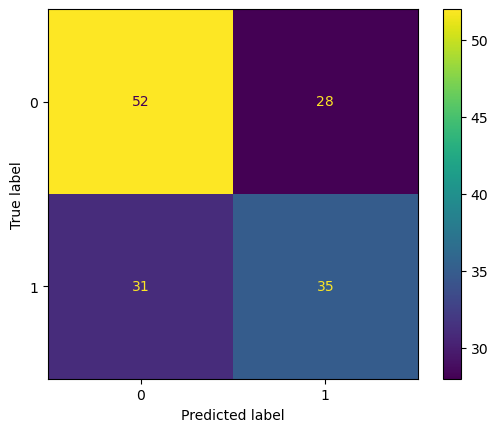

In [40]:
# Generate predictions with the best model
y_pred_tree1 = best_rf_tree1.predict(X_test_tree1)

# Create the confusion matrix
cm_tree1 = confusion_matrix(y_test_tree1, y_pred_tree1)

ConfusionMatrixDisplay(confusion_matrix=cm_tree1).plot();

In [41]:
accuracy_tree1 = accuracy_score(y_test_tree1, y_pred_tree1)
precision_tree1 = precision_score(y_test_tree1, y_pred_tree1)
recall_tree1 = recall_score(y_test_tree1, y_pred_tree1)

print("Accuracy:", accuracy_tree1)
print("Precision:", precision_tree1)
print("Recall:", recall_tree1)

Accuracy: 0.5958904109589042
Precision: 0.5555555555555556
Recall: 0.5303030303030303


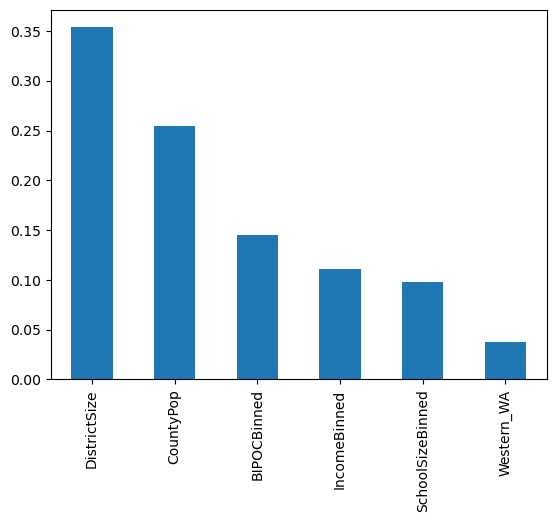

In [42]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances_tree1 = pd.Series(best_rf_tree1.feature_importances_, index=X_train_tree1.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances_tree1.plot.bar();

Best hyperparameters: {'max_depth': 5, 'n_estimators': 368}


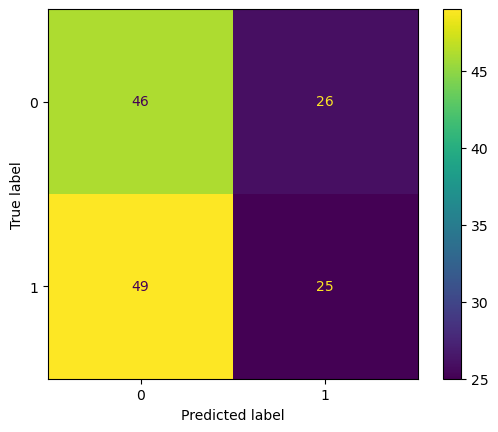

In [43]:
X_rf3 = df_for_tree_v3.drop(['CS_Offered'], axis = 1)
y_rf3 = df_for_tree_v3['CS_Offered']
X_train_rf3, X_test_rf3, y_train_rf3, y_test_rf3 = train_test_split(X_rf3, y_rf3, test_size=0.2)
param_dist_rf3 = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf_rf3 = RandomForestClassifier(random_state=25)

# Use random search to find the best hyperparameters
rand_search_rf3 = RandomizedSearchCV(rf_rf3, 
                                 param_distributions = param_dist_rf3, 
                                 n_iter=5, 
                                 cv=5,
                                 random_state=25)

# Fit the random search object to the data
rand_search_rf3.fit(X_train_rf3, y_train_rf3)
# Create a variable for the best model
best_rf_rf3 = rand_search_rf3.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search_rf3.best_params_)
# Generate predictions with the best model
y_pred_rf3 = best_rf_rf3.predict(X_test_rf3)
# Generate predictions with the best model
y_pred_rf3 = best_rf_rf3.predict(X_test_rf3)

# Create the confusion matrix
cm_rf3 = confusion_matrix(y_test_rf3, y_pred_rf3)

ConfusionMatrixDisplay(confusion_matrix=cm_rf3).plot();

In [44]:
accuracy_rf3 = accuracy_score(y_test_rf3, y_pred_rf3)
precision_rf3 = precision_score(y_test_rf3, y_pred_rf3)
recall_rf3 = recall_score(y_test_rf3, y_pred_rf3)

print("Accuracy:", accuracy_rf3)
print("Precision:", precision_rf3)
print("Recall:", recall_rf3)

Accuracy: 0.4863013698630137
Precision: 0.49019607843137253
Recall: 0.33783783783783783


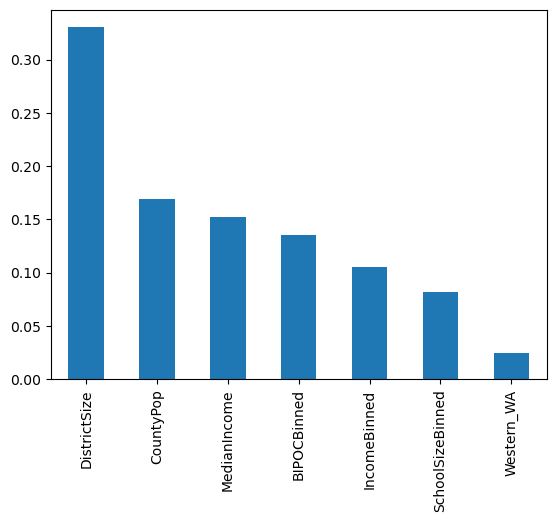

In [45]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances_tree3 = pd.Series(best_rf_rf3.feature_importances_, index=X_train_rf3.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances_tree3.plot.bar();

Best hyperparameters: {'max_depth': 5, 'n_estimators': 368}


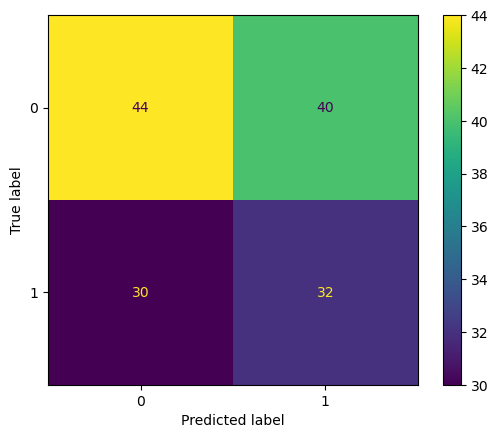

In [46]:
X_rf4 = df_for_tree_v4.drop(['CS_Offered'], axis = 1)
y_rf4 = df_for_tree_v4['CS_Offered']
X_train_rf4, X_test_rf4, y_train_rf4, y_test_rf4 = train_test_split(X_rf4, y_rf4, test_size=0.2)
param_dist_rf4 = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf_rf4 = RandomForestClassifier(random_state=25)

# Use random search to find the best hyperparameters
rand_search_rf4 = RandomizedSearchCV(rf_rf4, 
                                 param_distributions = param_dist_rf4, 
                                 n_iter=5, 
                                 cv=5,
                                 random_state=25 )

# Fit the random search object to the data
rand_search_rf4.fit(X_train_rf4, y_train_rf4)
# Create a variable for the best model
best_rf_rf4 = rand_search_rf4.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search_rf4.best_params_)
# Generate predictions with the best model
y_pred_rf4 = best_rf_rf4.predict(X_test_rf4)
# Generate predictions with the best model
y_pred_rf4 = best_rf_rf4.predict(X_test_rf4)

# Create the confusion matrix
cm_rf4 = confusion_matrix(y_test_rf4, y_pred_rf4)

ConfusionMatrixDisplay(confusion_matrix=cm_rf4).plot();

In [47]:
accuracy_rf4 = accuracy_score(y_test_rf4, y_pred_rf4)
precision_rf4 = precision_score(y_test_rf4, y_pred_rf4)
recall_rf4 = recall_score(y_test_rf4, y_pred_rf4)

print("Accuracy:", accuracy_rf4)
print("Precision:", precision_rf4)
print("Recall:", recall_rf4)

Accuracy: 0.5205479452054794
Precision: 0.4444444444444444
Recall: 0.5161290322580645


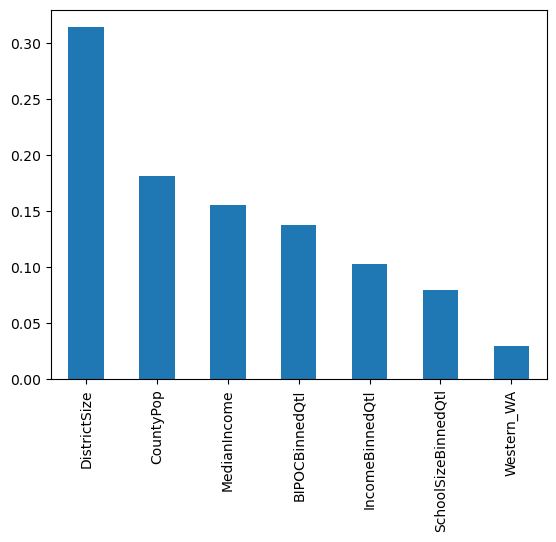

In [48]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances_tree4 = pd.Series(best_rf_rf4.feature_importances_, index=X_train_rf4.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances_tree4.plot.bar();

Best hyperparameters: {'max_depth': 5, 'n_estimators': 368}


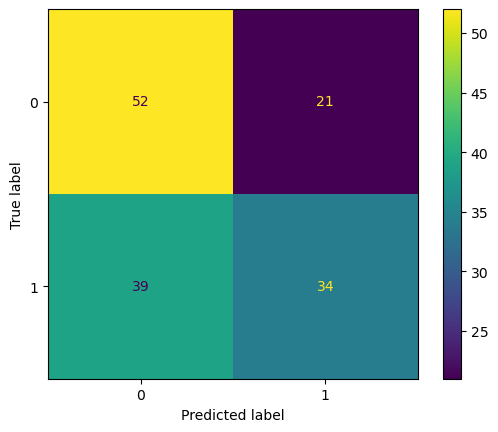

In [50]:
X_rf5 = df_for_tree_v5.drop(['CS_Offered'], axis = 1)
y_rf5 = df_for_tree_v5['CS_Offered']
X_train_rf5, X_test_rf5, y_train_rf5, y_test_rf5 = train_test_split(X_rf5, y_rf5, test_size=0.2)
param_dist_rf5 = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf_rf5 = RandomForestClassifier(random_state=25)

# Use random search to find the best hyperparameters
rand_search_rf5 = RandomizedSearchCV(rf_rf5, 
                                 param_distributions = param_dist_rf5, 
                                 n_iter=5, 
                                 cv=5,
                                 random_state=25)

# Fit the random search object to the data
rand_search_rf5.fit(X_train_rf5, y_train_rf5)
# Create a variable for the best model
best_rf_rf5 = rand_search_rf5.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search_rf5.best_params_)
# Generate predictions with the best model
y_pred_rf5 = best_rf_rf5.predict(X_test_rf5)
# Generate predictions with the best model
y_pred_rf5 = best_rf_rf5.predict(X_test_rf5)

# Create the confusion matrix
cm_rf5 = confusion_matrix(y_test_rf5, y_pred_rf5)

ConfusionMatrixDisplay(confusion_matrix=cm_rf5).plot();

In [51]:
accuracy_rf5 = accuracy_score(y_test_rf5, y_pred_rf5)
precision_rf5 = precision_score(y_test_rf5, y_pred_rf5)
recall_rf5 = recall_score(y_test_rf5, y_pred_rf5)

print("Accuracy:", accuracy_rf5)
print("Precision:", precision_rf5)
print("Recall:", recall_rf5)

Accuracy: 0.589041095890411
Precision: 0.6181818181818182
Recall: 0.4657534246575342


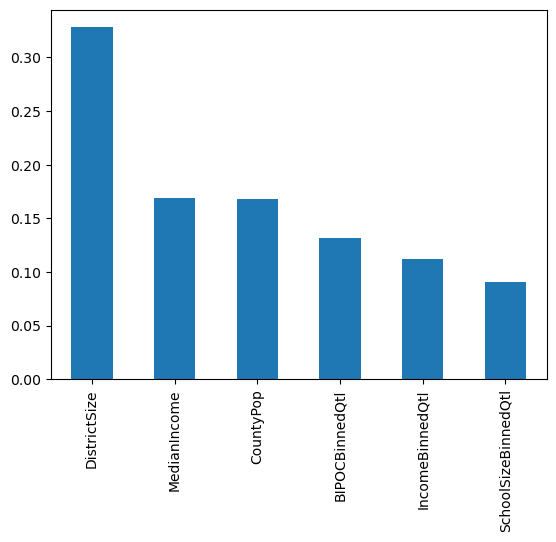

In [100]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances_tree5 = pd.Series(best_rf_rf5.feature_importances_, index=X_train_rf5.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances_tree5.plot.bar();

In [101]:
feature_importances_tree5

DistrictSize           0.328229
MedianIncome           0.169195
CountyPop              0.167904
BIPOCBinnedQtl         0.132078
IncomeBinnedQtl        0.112070
SchoolSizeBinnedQtl    0.090524
dtype: float64

### Analysis: Examining the most successful random forest model further

In [99]:
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance

# Perform cross-validation with return of fitted models
cv_results = cross_validate(rf_rf5, X_rf5, y_rf5, cv=5, return_estimator=True, scoring='accuracy')

# Collect Gini importance from each fold
feature_importances_k = [estimator.feature_importances_ for estimator in cv_results['estimator']]

# Calculate mean and standard deviation of feature importance across folds
importance_df = pd.DataFrame(feature_importances_k, columns=X_rf5.columns)
mean_importance = importance_df.mean()
std_importance = importance_df.std()

# Display feature importance summary
importance_summary = pd.DataFrame({
    'Feature': X_rf5.columns,
    'Mean Gini Importance': mean_importance,
    'Standard Deviation': std_importance
}).sort_values(by='Mean Gini Importance', ascending=False)

print("Feature Importance from Gini Index (Cross-Validation):")
print(importance_summary)

# Fit the model on the entire dataset to get permutation importance
rf_rf5.fit(X_rf5, y_rf5)
perm_importance = permutation_importance(rf_rf5, X_rf5, y_rf5, scoring='accuracy', n_repeats=10, random_state=52)

# Display permutation importance results
perm_importance_df = pd.DataFrame({
    'Feature': X_rf5.columns,
    'Permutation Importance': perm_importance.importances_mean
}).sort_values(by='Permutation Importance', ascending=False)

print("\nFeature Importance from Permutation:")
print(perm_importance_df)

Feature Importance from Gini Index (Cross-Validation):
                                 Feature  Mean Gini Importance  \
DistrictSize                DistrictSize              0.316433   
BIPOCBinnedQtl            BIPOCBinnedQtl              0.146731   
IncomeBinnedQtl          IncomeBinnedQtl              0.139536   
SchoolSizeBinnedQtl  SchoolSizeBinnedQtl              0.137218   
CountyPop                      CountyPop              0.133225   
MedianIncome                MedianIncome              0.126857   

                     Standard Deviation  
DistrictSize                   0.010141  
BIPOCBinnedQtl                 0.006720  
IncomeBinnedQtl                0.005827  
SchoolSizeBinnedQtl            0.004234  
CountyPop                      0.008419  
MedianIncome                   0.007127  

Feature Importance from Permutation:
               Feature  Permutation Importance
1         DistrictSize                0.282603
4       BIPOCBinnedQtl                0.226575
2      In

This shows that we can more confidently interpret the feature importance from this random forest model. This shows consistency across gini index and permutation importance. Furthermore:

* Both methods rank DistrictSize as the most important feature, with a significant gap between it and the other features.
* The second and third features (BIPOCBinnedQtl and IncomeBinnedQtl) also rank highly and consistently across both methods.
* This consistency indicates that these features have a stable and meaningful impact on the model’s predictions.
* Features like DistrictSize likely have a strong direct relationship with the target variable.
* Since both Gini and permutation methods agree on these rankings, we can be confident that these features are not artifacts of overfitting or model-specific biases.

### Analysis: Logistic Regression
### Correlation Heatmap
*To ensure there is not multicollinearity with our independent variables*

In [56]:
df_logistic_reg = with_income.loc[:, ('CountyPop','Western_WA','DistrictSize','CS_Offered','IncomeBinnedQtl','SchoolSizeBinnedQtl','BIPOCBinnedQtl','MedianIncome')]

In [57]:
df_logistic_reg['IncomeBinnedQtl'] = df_logistic_reg['IncomeBinnedQtl'].cat.codes
df_logistic_reg['SchoolSizeBinnedQtl'] = df_logistic_reg['SchoolSizeBinnedQtl'].cat.codes
df_logistic_reg['BIPOCBinnedQtl'] = df_logistic_reg['BIPOCBinnedQtl'].cat.codes

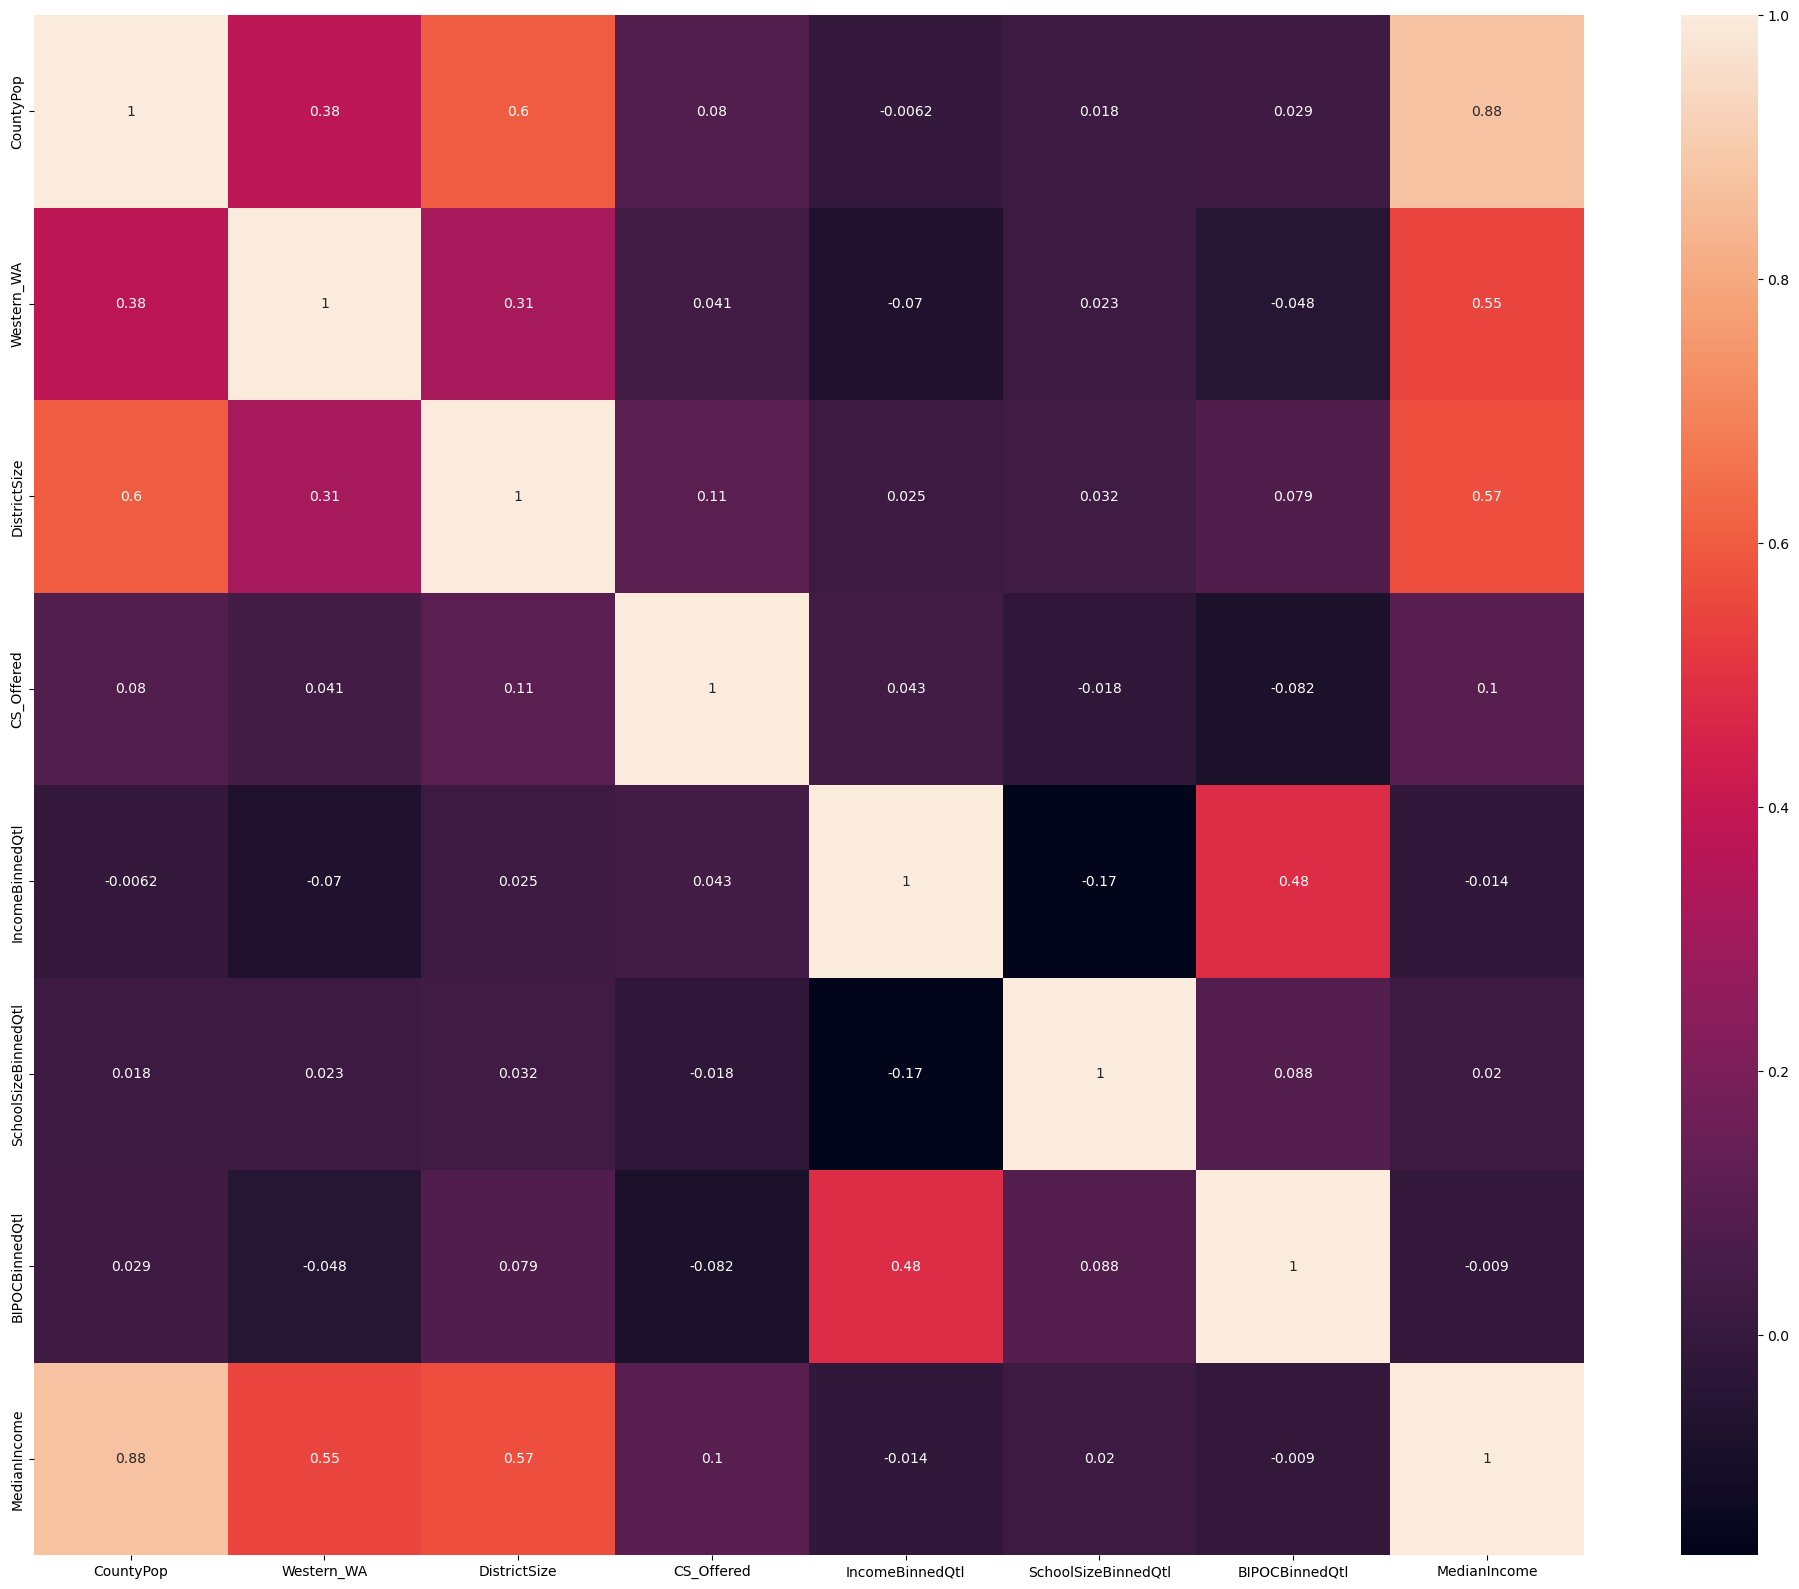

In [58]:
fig = plt.figure(figsize=(25, 20))
sns.heatmap(df_logistic_reg.corr(), annot=True)
plt.savefig("Heatmap.png")

Two of these features have a high correlation between MedianIncome and CountyPop.

We can: 
* **Drop one of them, perhaps by using what we've learned in the feature importance above that is related to the random forest analysis**
* Combine the two, either by adding the two, averaging the two or combining with the help of PCA
* Experiment with all of the above

None of the rest of the features have high correlation (over .7) with one another, so we can include them in this analysis. Keeping in mind that the sample size may not be large enough to yield significant results. Four features with the next highest correlation to be mindful of:

* DistrictSize and CountyPop: .6
* IncomeBinned and BIPOCBinned: .49

Something else interesting to note with this correlation heatmap is that IncomeBinnedQtl and MedianIncome do not show much of a correlation. A probable explanation for this is the wide range of income levels between schools in the same county. This further supports the hypothesis that the school a student attends has the highest predictive value as to whether the student enrolls in CS or not. The individual traits and the broader county that they live in are less likely to influence their enrollment than the school they attend.

In [59]:
df_logistic_reg1 = with_income.loc[:, ('CountyPop','Western_WA','DistrictNumSchools','DistrictSize','CS_Offered','IncomeBinnedQtl','SchoolSizeBinnedQtl','BIPOCBinnedQtl')]
df_logistic_reg1['IncomeBinnedQtl'] = df_logistic_reg1['IncomeBinnedQtl'].cat.codes
df_logistic_reg1['SchoolSizeBinnedQtl'] = df_logistic_reg1['SchoolSizeBinnedQtl'].cat.codes
df_logistic_reg1['BIPOCBinnedQtl'] = df_logistic_reg1['BIPOCBinnedQtl'].cat.codes

In [60]:
X_lr1 = df_logistic_reg1.drop(['CS_Offered'], axis = 1)
y_lr1 = df_logistic_reg1['CS_Offered']

scaler = StandardScaler()
X_scaled_lr1 = scaler.fit_transform(X_lr1)

X_train_lr1, X_test_lr1, y_train_lr1, y_test_lr1 = train_test_split(X_lr1, y_lr1, test_size=0.3, random_state=0)
logreg_lr1 = LogisticRegression()
logreg_lr1.fit(X_train_lr1, y_train_lr1)

LogisticRegression()

In [61]:
y_pred_lr1 = logreg_lr1.predict(X_test_lr1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_lr1.score(X_test_lr1, y_test_lr1)))

Accuracy of logistic regression classifier on test set: 0.49


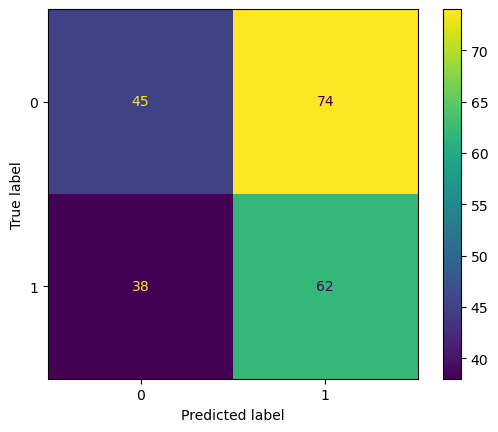

In [62]:
cm_lr1 = confusion_matrix(y_test_lr1, y_pred_lr1)

ConfusionMatrixDisplay(confusion_matrix=cm_lr1).plot();

The inaccuracy here may be due to the insufficient amount of data. Another possible reason is that the relationships in the data are likely non-linear and cannot be effectively modeled with a simple linear decision boundary.

### Analysis: PCA  

Eigenvalues:
[2.3809603  1.50567788 1.05969767 0.5132515  0.42483321 0.1238099 ]

Variances (Percentage):
[39.62831181 25.06025514 17.63743375  8.54247351  7.07085415  2.06067164]



Text(0, 0.5, 'Explained variance (%)')

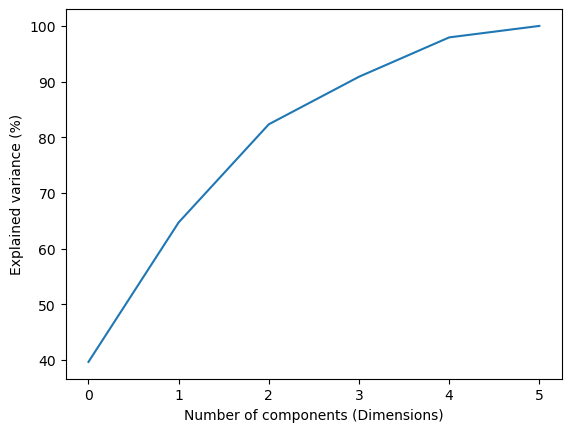

In [63]:
# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

In [64]:
feature_names = X_to_scale.columns
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], index=feature_names)
loading_matrix

,PC1,PC2,PC3,PC4,PC5,PC6
CountyPop,0.937896,-0.023671,-0.051433,-0.210180,0.101394,-0.253102
DistrictSize,0.797399,0.050294,0.027813,0.551234,-0.241181,0.014025
IncomeBinned,0.003112,0.878932,-0.145764,-0.231851,-0.392218,-0.002046
SchoolSizeBinned,0.061702,-0.165257,0.958832,-0.133283,-0.181971,-0.004151
BIPOCBinned,0.038431,0.837046,0.336536,0.163884,0.398860,0.006716
MedianIncome,0.927455,-0.045943,-0.049146,-0.258535,0.101720,0.243898


In [65]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance explained:", pca.explained_variance_ratio_.cumsum())

Explained variance ratio: [0.39628312 0.25060255 0.17637434 0.08542474 0.07070854 0.02060672]
Cumulative variance explained: [0.39628312 0.64688567 0.82326001 0.90868474 0.97939328 1.        ]


### Principal Components: Key Contributing Features
* **PC1 (40%)**:  CountyPop, DistrictSize, MedianIncome

* **PC2 (25%)**:  IncomeBinned, BIPOCBinned

* **PC3 (18%)**:  SchoolSizeBinned

* **PC4 (9%)**:  CountyPop, DistrictNumSchools, MedianIncome (*.4 < loadings < .5*, but strongest of this PC)

* **PC5 (7%)**:  IncomeBinned, BIPOCBinned (*.4 < loadings < .5*, but strongest of this PC)

* **PC6-PC7 (2%%)**: No strong contributing features

This suggests that < elaborate >

### Mutual Information

<Axes: >

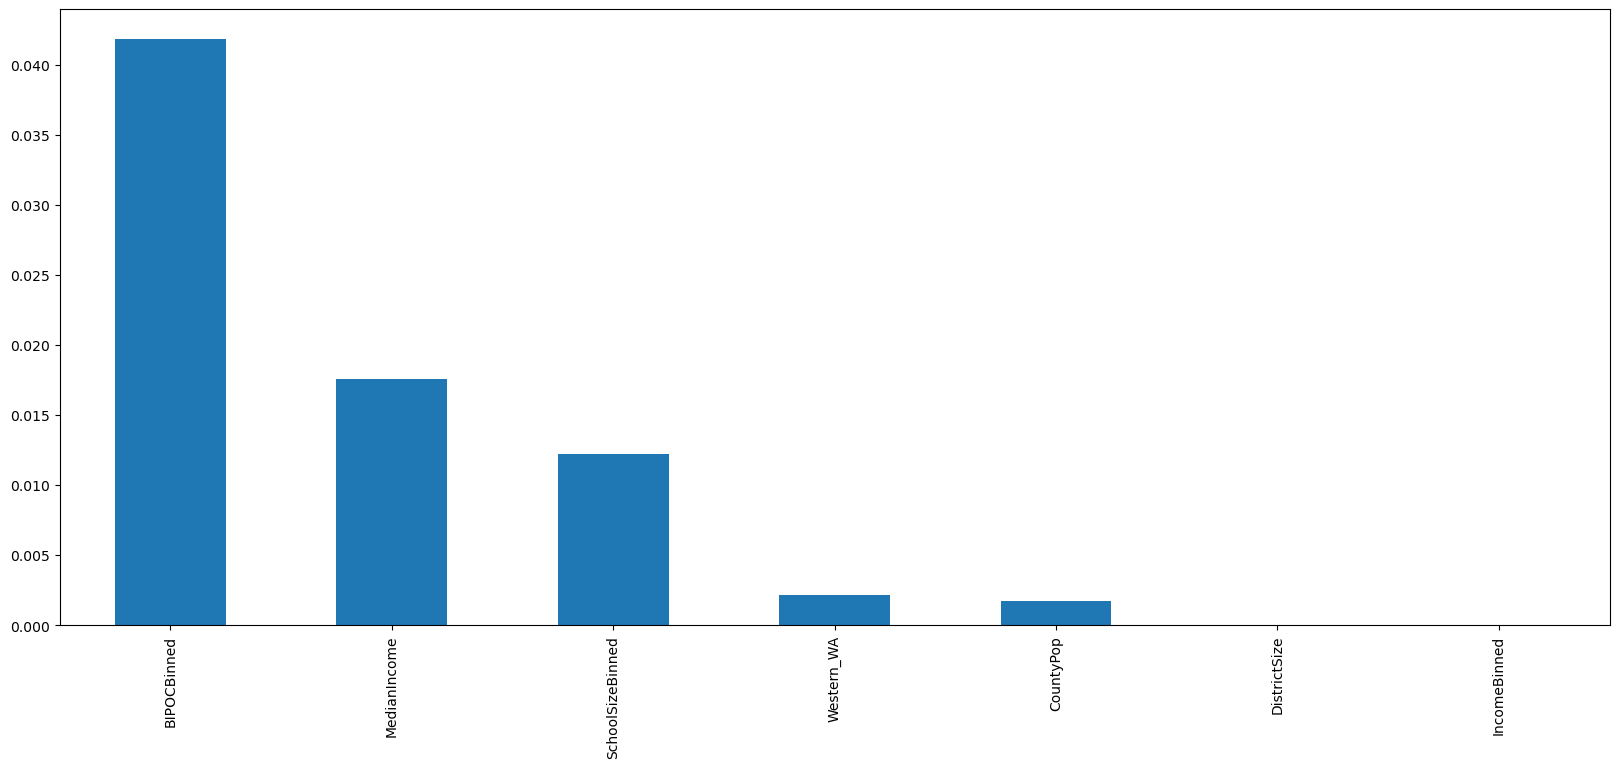

In [75]:
X_mi2 = X_to_scale2
y_mi2 = with_income['CS_Offered']
X_train_mi2, X_test_mi2, y_train_mi2, y_test_mi2 = train_test_split(X_mi2, y_mi2, test_size=0.2, random_state=1234)

from sklearn.feature_selection import mutual_info_classif
mutual_info2 = mutual_info_classif(X_train_mi2, y_train_mi2)


mutual_info2 = pd.Series(mutual_info2)
mutual_info2.index = X_train_mi2.columns
mutual_info2.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [76]:
X_mi = X_to_scale3
y_mi = with_income['CS_Offered']
X_train_mi, X_test_mi, y_train_mi, y_test_mi = train_test_split(X_mi, y_mi, test_size=0.2, random_state=1234)

In [77]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train_mi, y_train_mi)
mutual_info

array([0.03130723, 0.01876729, 0.04057258, 0.24432328, 0.05080929,
       0.03342445, 0.01588637])

<Axes: >

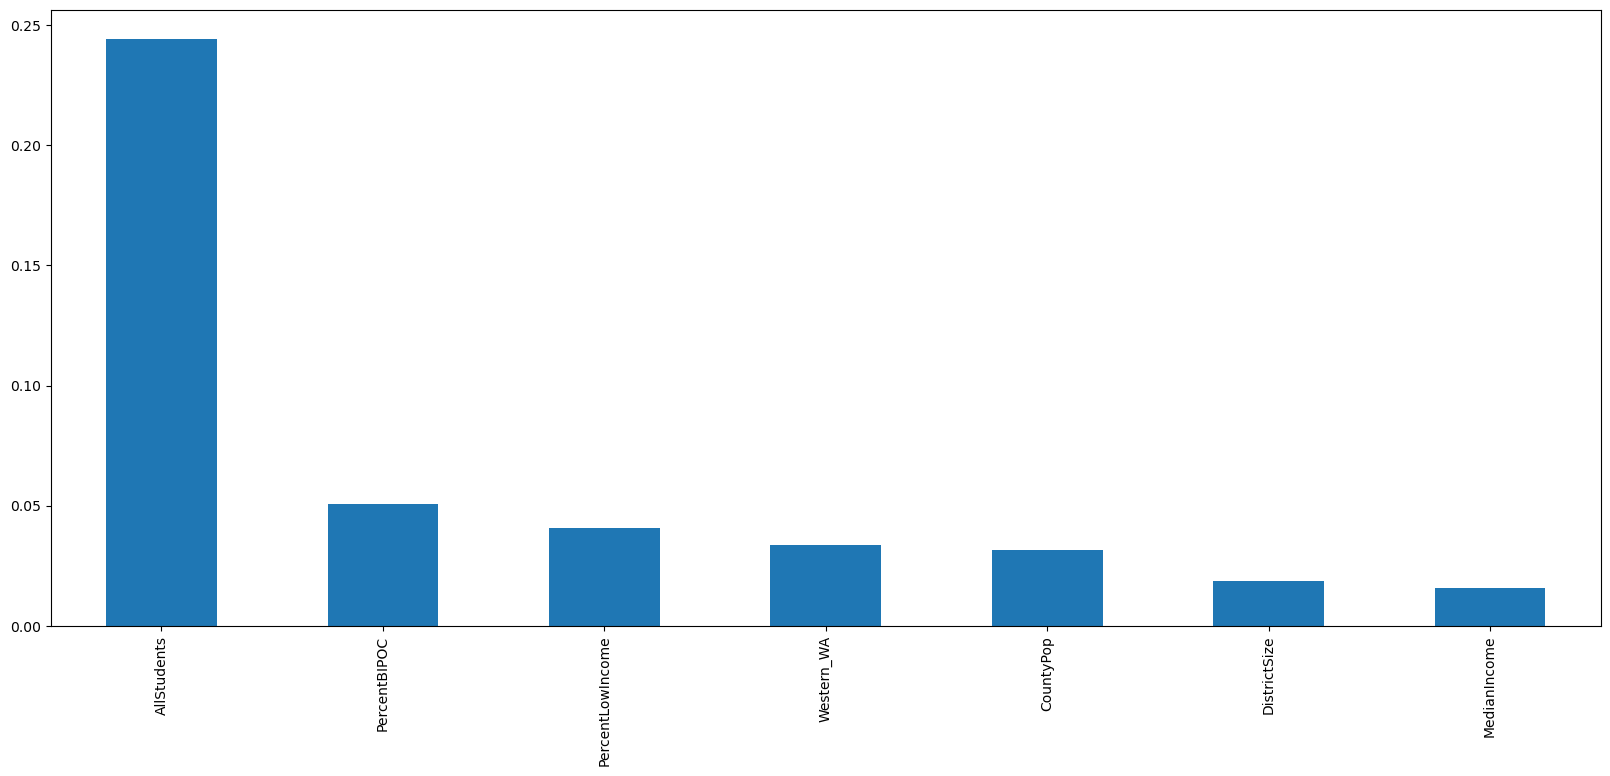

In [78]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_mi.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

### Analysis: Comparing principle components and feature importance from different techniques

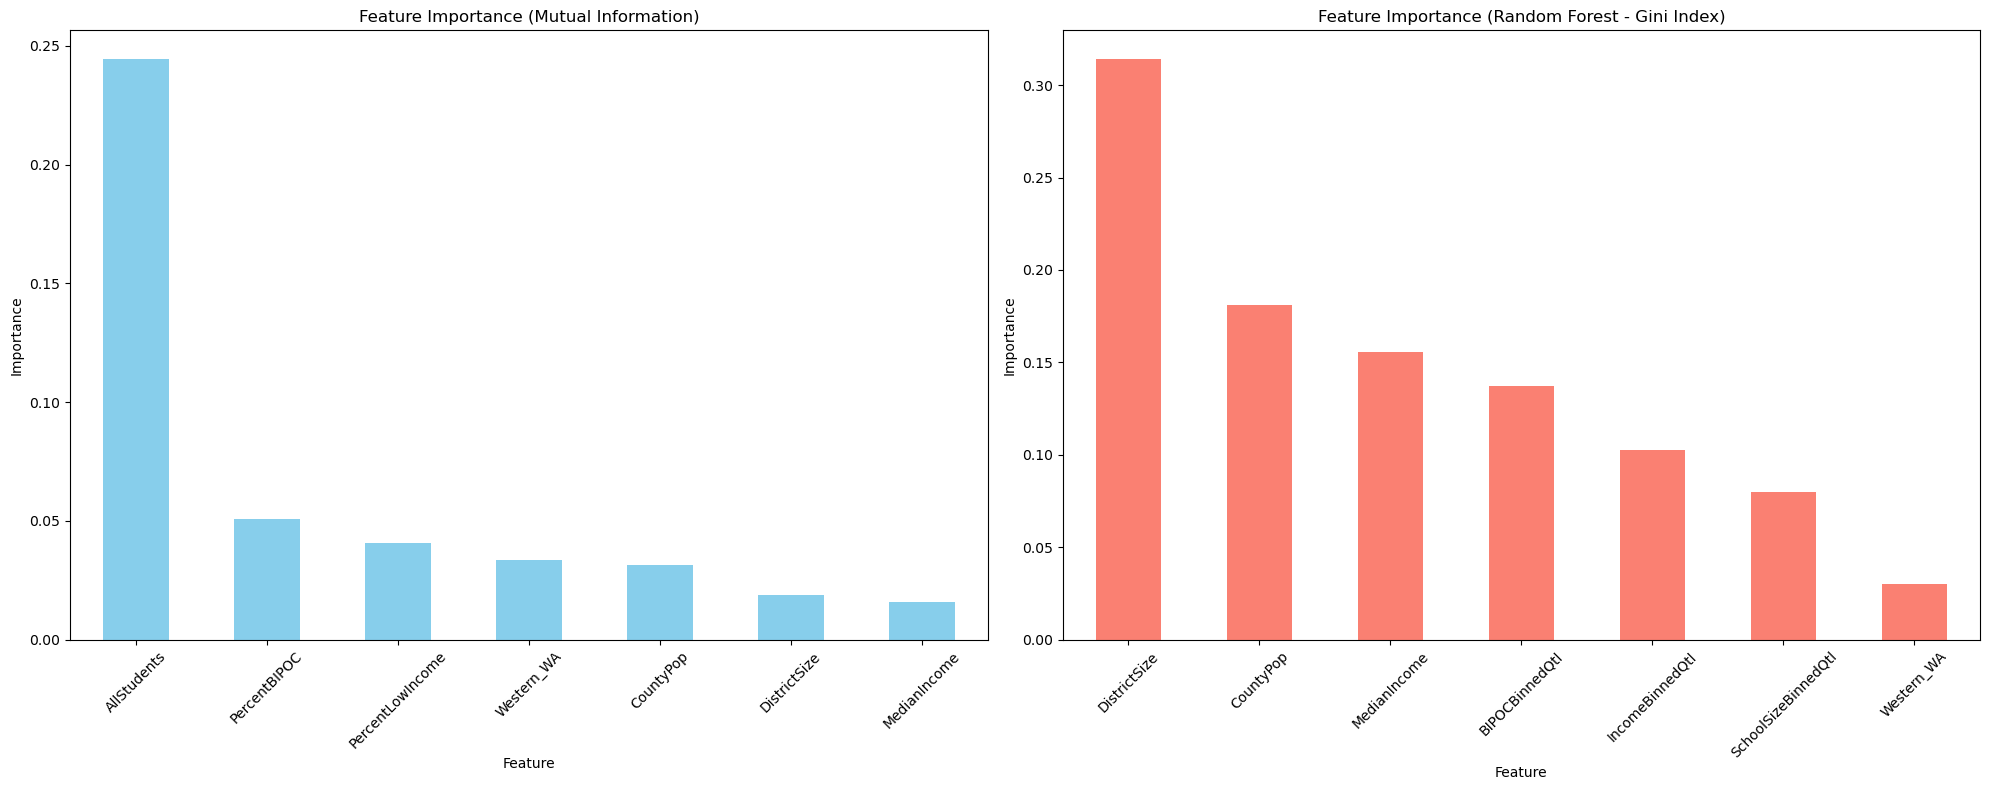

In [79]:
# Ensure mutual_info is a Pandas Series with feature names
mutual_info_series = pd.Series(mutual_info, index=X_train_mi.columns).sort_values(ascending=False)

# Ensure feature_importances_tree4 is a Pandas Series
feature_importances_series = feature_importances_tree4.sort_values(ascending=False)

# Plot both charts side by side using subplots
plt.figure(figsize=(20, 8))

# Mutual Information bar chart
plt.subplot(1, 2, 1)
mutual_info_series.plot.bar(color='skyblue')
plt.title('Feature Importance (Mutual Information)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)

# Feature Importance (Random Forest) bar chart
plt.subplot(1, 2, 2)
feature_importances_series.plot.bar(color='salmon')
plt.title('Feature Importance (Random Forest - Gini Index)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [82]:
feature_names = X_to_scale.columns
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], index=feature_names)
loading_matrix

,PC1,PC2,PC3,PC4,PC5,PC6
CountyPop,0.937896,-0.023671,-0.051433,-0.210180,0.101394,-0.253102
DistrictSize,0.797399,0.050294,0.027813,0.551234,-0.241181,0.014025
IncomeBinned,0.003112,0.878932,-0.145764,-0.231851,-0.392218,-0.002046
SchoolSizeBinned,0.061702,-0.165257,0.958832,-0.133283,-0.181971,-0.004151
BIPOCBinned,0.038431,0.837046,0.336536,0.163884,0.398860,0.006716
MedianIncome,0.927455,-0.045943,-0.049146,-0.258535,0.101720,0.243898


### Why are there differences and what does that tell us?

Feature importance rankings varied across Random Forest (RF), Mutual Information (MI), and Principal Component Analysis (PCA), reflecting how each method captures relationships between features and the target variable.

The Random Forest model's feature importance rankings (both from the model itself and through Gini Index and Permutation Importance) consistently highlighted District Size as the dominant predictor of whether a school offers CS, followed by Median Income, County Population, and demographic factors like BIPOC and Income Binning. Across all RF-based methods, these features were stable in their rankings, suggesting that CS availability is largely driven by district size and economic conditions.

Mutual Information (MI), however, produced different rankings, prioritizing BIPOCBinned, Median Income, SchoolSizeBinned, Western_WA, and County Population. Unlike RF, which accounts for feature interactions, MI identifies direct statistical dependencies between a single feature and the target. The fact that District Size ranked low or was missing entirely suggests that its effect is more indirect, possibly interacting with other variables like County Population or Median Income.

PCA aligned more closely with Random Forest than with MI. The top three RF features—County Population, District Size, and Median Income—also had the highest loadings in PC1, meaning they explain the most variance in the dataset. IncomeBinned and BIPOCBinned formed PC2, reinforcing that these factors may work together rather than acting independently. Recall that when we observed the correlation heatmap that County Population and District Size, understandably, had some correlation (.6) and IncomeBinned and BIPOCBinned had a correlation of .49, further supporting this idea. SchoolSizeBinned dominated PC3, confirming its role in explaining variance.

#### Key Takeaways
* RF and PCA align, suggesting that District Size, County Population, and Median Income are structurally important factors in CS course availability.
* Mutual Information does not account for feature interactions, leading to a different ranking that may overlook complex dependencies.
* PCA confirms that socioeconomic and demographic factors do not act independently but are better understood in combination.

## IV. Conclusion

This study aimed to identify what traits distinguish schools that offer Computer Science (CS) courses from those that do not. To achieve this, we leveraged explainability techniques in machine learning models, including Random Forest feature importance, PCA, and Mutual Information, to assess which factors most strongly contribute to CS availability.

A consistent finding across models was that District Size is the strongest predictor of CS course availability. Regardless of whether feature importance was measured through Gini Index, Permutation Importance, or PCA loadings, District Size remained the most influential factor. Larger school districts were more likely to offer CS courses, suggesting that district-wide policies, funding availability, and resource allocation play a critical role in determining access to CS education.

Economic and population-related factors, particularly Median Income and County Population, also emerged as important contributors. These features were consistently ranked among the top predictors, reinforcing the idea that schools in wealthier or more populous areas have greater access to CS programs. While we removed highly correlated features (above 0.7), some level of interaction remained, as seen in PCA results, where County Population, District Size, and Median Income together dominated PC1, the principal component explaining the most variance in the dataset.

Socioeconomic and demographic characteristics, including BIPOC student representation and income levels, also played a role but in a more complex way. Unlike District Size, which was a dominant individual predictor, these factors were more impactful when considered together. PCA grouped Income and BIPOC percentage into PC2, suggesting that CS offerings are influenced by how these factors intersect rather than by any one factor in isolation. This may also explain why Mutual Information produced rankings that differed from Random Forest and PCA, as MI evaluates features independently rather than in relation to one another.

An additional indicator that feature relationships were non-linear and interaction-driven was the poor performance of Logistic Regression compared to tree-based models. If CS course availability followed a simple, linear pattern, we would expect Logistic Regression to perform well. Instead, its significantly lower predictive power suggests that CS availability is shaped by complex interactions between school characteristics, rather than singular direct effects.

These findings have important implications. Since district size, economic factors, and school demographics together shape CS access, policies aimed at expanding CS education should focus on smaller districts and lower-income areas, where CS courses are less common. Simply increasing school funding may not be enough; targeted interventions, such as district-wide CS initiatives or state-level funding for underserved communities, may be necessary to close the access gap. Future research could further explore how school district policies influence CS course offerings and whether direct interventions, such as requiring CS curricula at the state level, could drive more equitable distribution of CS education.

By using multiple explainability techniques, this study demonstrates the value of going beyond standard predictive models to understand systemic patterns in education access. Leveraging machine learning interpretability allows us to move from prediction to action, ensuring that insights from data can help shape more equitable CS education policies.